<a href="https://colab.research.google.com/github/shreyab375/LSTM-Forecasting-Models-/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Reade the data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snv1_full.csv', sep=",", header=0)
#convert the date to datetime format
data.Date = pd.to_datetime(data.Date)

In [6]:
#Select the values from 1900 to avoid any data gaps
data = data.set_index('Date')
data = data.truncate(before = '1850-01-01', after ='2024-01-01')
data = data.reset_index()

In [7]:
data.set_index('Date',inplace=True)

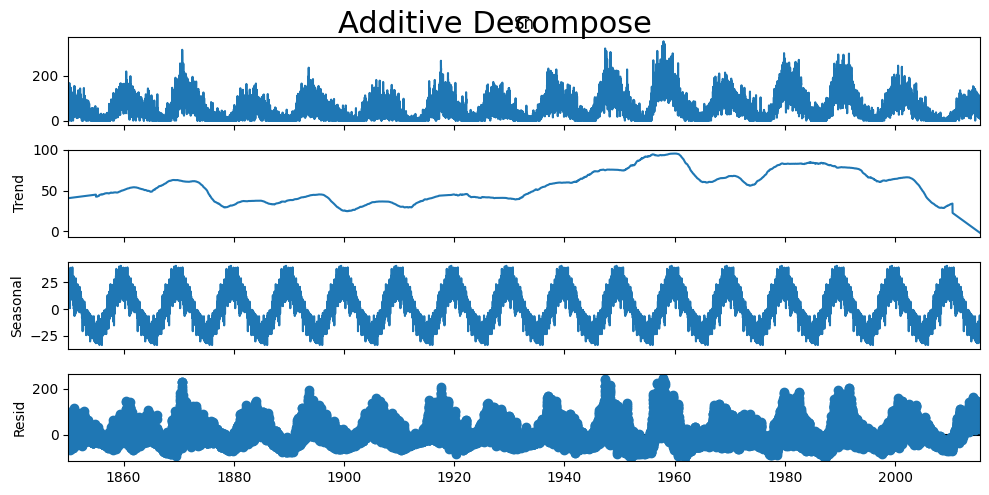

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
# Multiplicative Decomposition
#result_mul = seasonal_decompose(data['Total_Sunspots'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(data['Sn'], model='additive', extrapolate_trend='freq',period=3650)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Detrending Manually

In [9]:
data['rolling_mean'] = data['Sn'].rolling(2000, min_periods=1).mean().transform(lambda x: x.ffill())
data['Detrend'] = data['Sn'] - data['rolling_mean']
data

,Sn,rolling_mean,Detrend
Date,,,
1850-01-01,133,133.000000,0.000000
1850-01-02,85,109.000000,-24.000000
1850-01-03,114,110.666667,3.333333
1850-01-04,52,96.000000,-44.000000
1850-01-05,57,88.200000,-31.200000
...,...,...,...
2015-05-27,9,54.103500,-45.103500
2015-05-28,8,54.107500,-46.107500
2015-05-29,22,54.118500,-32.118500


Text(0.5, 1.0, 'Detrended')

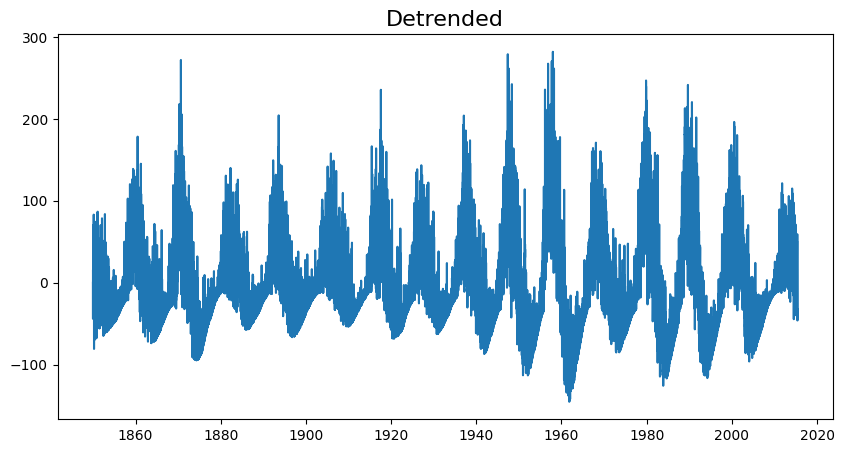

In [10]:
plt.plot(data['Detrend'])
plt.title('Detrended',fontsize=16)

Detrending using seasonal_decompose

Text(0.5, 1.0, 'Sunspot Number detrended by subtracting the trend component')

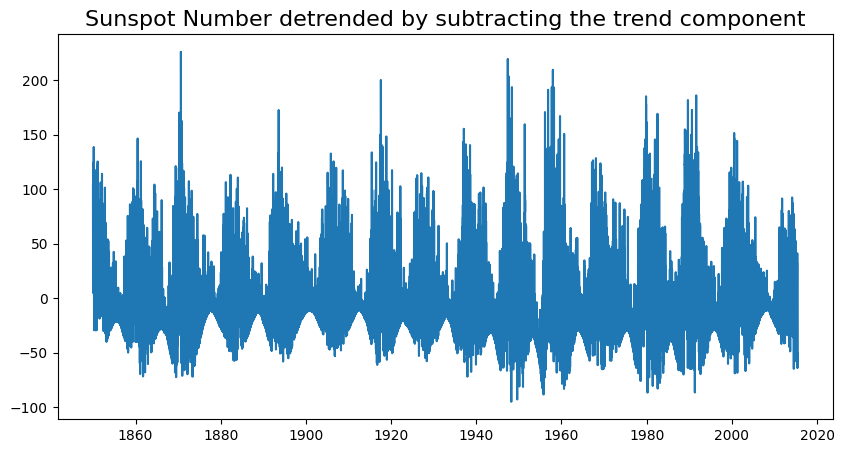

In [11]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data['Sn'], model='add', extrapolate_trend='freq',period=2000)
detrended = data.Sn.values -result_add.trend
plt.plot(detrended)
plt.title('Sunspot Number detrended by subtracting the trend component', fontsize=16)

Deseasonalizing using seasonal decompose

Text(0.5, 1.0, 'Sunspot Number deseasonalized by subtracting the seasonal component')

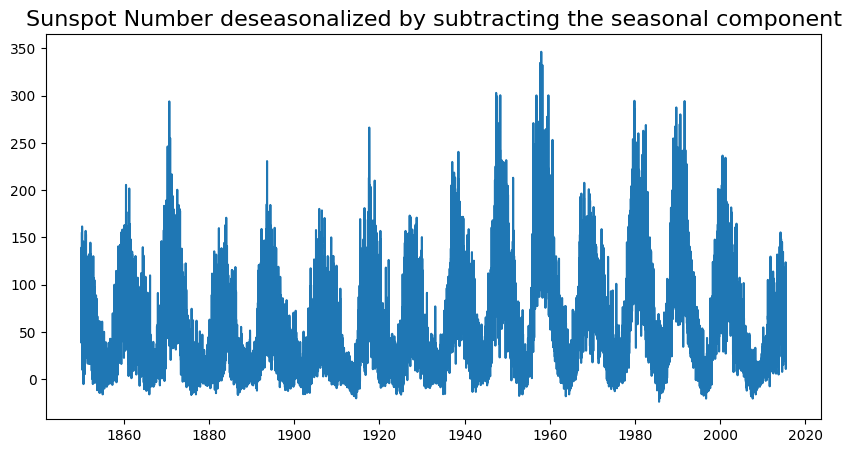

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(data['Sn'], model='add', extrapolate_trend='freq',period=2000)
deseasonalized = data.Sn.values -result_add.seasonal
plt.plot(deseasonalized)
plt.title('Sunspot Number deseasonalized by subtracting the seasonal component', fontsize=16)

Autocorrelation plot

This helps us to find if current value depends on previous values. In the plot you can observe that current value is dependent on previous values.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

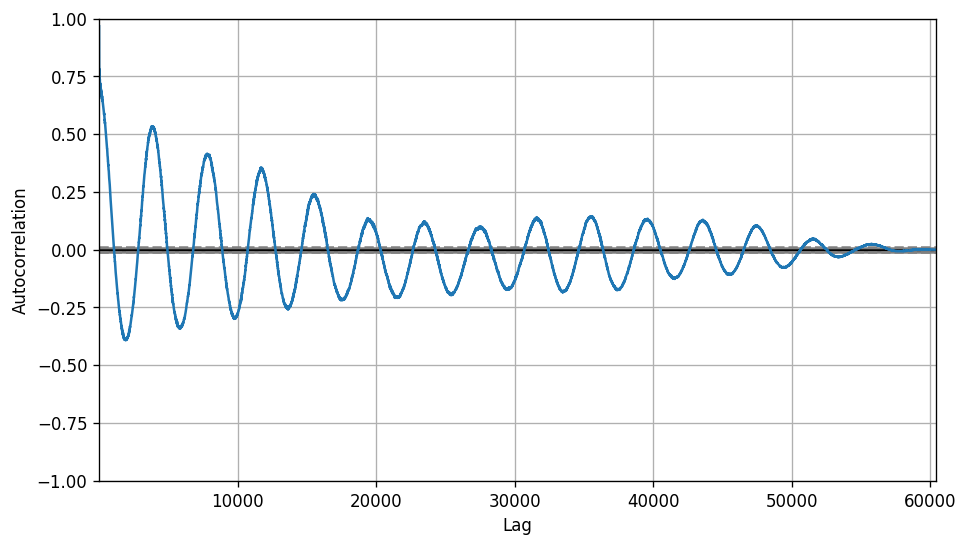

In [13]:
from pandas.plotting import autocorrelation_plot


# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data['Sn'].tolist())

acf plot helps us understand whether the data in additive or multiplicatve in some way. By looking at the plot we can improvise our understanding from above plot and say that present value depends on previous 20-25 values.

pacf plot further says that present value depends only on previous 3 values. All these plots help us narrow down thinking and make our model efficient.

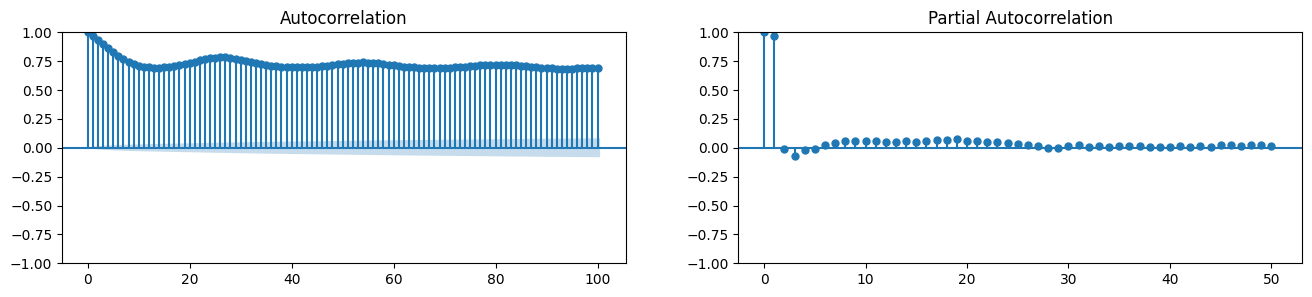

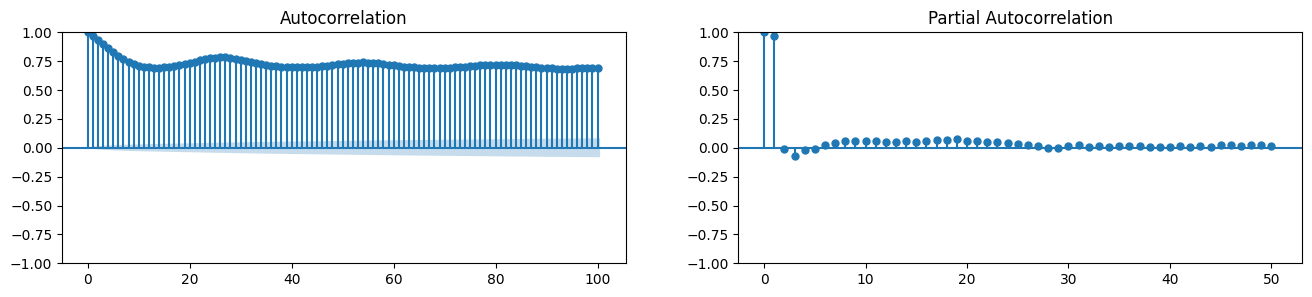

In [14]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['Sn'].tolist(), lags=100, ax=axes[0])
plot_pacf(data['Sn'].tolist(), lags=50, ax=axes[1])

In [15]:
count = int(data.shape[0]*0.8)
Train = data[:count]
Test = data[count:]


In [16]:
Train

,Sn,rolling_mean,Detrend
Date,,,
1850-01-01,133,133.000000,0.000000
1850-01-02,85,109.000000,-24.000000
1850-01-03,114,110.666667,3.333333
1850-01-04,52,96.000000,-44.000000
1850-01-05,57,88.200000,-31.200000
...,...,...,...
1982-04-26,150,112.533500,37.466500
1982-04-27,126,112.596500,13.403500
1982-04-28,90,112.641500,-22.641500


##ARIMA Model


We make a list for training data and we will be predicting next day's Sn with this data. Later the predicted value is appended to training data and next day's value is predicted again. This is repeated for all the test data.

ARIMA's forecast function gives 4 outputs.

predicted value

standard error

lower and upper confidance values which are very important when predicting on time series data.

In [17]:
# Assuming df is your DataFrame and 'Sn' is your target variable
split_ratio = 0.8  # For 80% training data
n_train = int(len(data) * split_ratio)

# Splitting data into training and testing sets
Train = data['Sn'][:n_train].tolist()  # Convert to a list for training
Test = data['Sn'][n_train:].tolist()  # Convert to a list for testing

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize variables
predictions = []
lower_list = []
upper_list = []

# Assume Train is your training data and Test is your testing data
history = [x for x in Train]

# SARIMA parameters
p, d, q = 5, 0, 1  # ARIMA order
P, D, Q, S = 1, 0, 1, 27  # Seasonal order (P, D, Q, S), where S is 27 days

# Loop through the test dataset
for t in range(len(Test)):
    # Fit SARIMA model with specified seasonal order
    model = SARIMAX(history, order=(p, d, q), seasonal_order=(P, D, Q, S))
    model_fit = model.fit(disp=False)  # Use disp=False in the newer version

    # Forecast the next value
    output = model_fit.get_forecast(steps=1)
    yhat = output.predicted_mean[0]  # Get the forecasted value
    conf_int = output.conf_int()  # Get the confidence interval
    lower = conf_int[0, 0]  # Lower bound of the forecast
    upper = conf_int[0, 1]  #
    # Append the predictions and bounds
    predictions.append(yhat)
    lower_list.append(lower)
    upper_list.append(upper)

    # Update the history with the true observation
    obs = Test[t]
    history.append(obs)

    # Print the prediction and actual value
    print(f'predicted={yhat:.6f}, expected={obs:.6f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=76.977852, expected=63.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=60.339070, expected=57.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
error = metrics.mean_squared_error(Test, predictions)
print('Test MSE: %.3f' % error)

The plot in the black color is original test values. The blue one is predicted values. The green and red plots are upper and lower confidance values respecctively.

In [ ]:
# plot
plt.plot(Test.values,color='black')
plt.plot(lower_list,color='red')
plt.plot(upper_list,color='green')
plt.plot(predictions)
plt.show()